In [1]:
import glob
import os
import omegaconf

import pandas as pd
import numpy as np
import random

import logging

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.decomposition import PCA

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns


logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)


In [2]:
path_champollion = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0"
participants_file = "/neurospin/dico/data/deep_folding/current/datasets/synesthetes/participants.csv"
embeddings_subpath = "synesthetes_random_embeddings/full_embeddings.csv"
ukb_embeddings_subpath = "ukb_random_embeddings/full_embeddings.csv"
participants_ukb_file = "/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/participants.csv"
output_filename = f"{path_champollion}/summary/isSynesthete_without_residualization.csv"
label = "isSynesthete"
covariates = ["Age", "brain_volume"]
max_iter = 2000
cv = 3

In [3]:
participants = pd.read_csv(participants_file, index_col=0)


In [4]:
participants.head()

,brain_volume,isSynesthete,NOM,DDN,IRM name,Date IRM,Age,Sex,Lateralite,Remarques,Code BV,Unnamed: 9,0=femme – 1=homme,0=droitier – 1=gaucher
participant_id,,,,,,,,,,,,,,
mv_SYNESTHEX_Sujet09_Session1_S2_T1w,1261229.989,0,PECL,12/8/1998,Control02,NaN,25.000000,1,0,Pas analysé,Sujet9,NaN,NaN,NaN
mv_SYNESTHEX_Sujet10_Session2_S14_T1w,1229268.222,0,VIMA,18/3/1985,Control27,28/2/2023,37.975342,0,0,NaN,Sujet10,NaN,NaN,NaN
mv_SYNESTHEX_Sujet11_Session2_S14_T1w,1026066.763,1,SICA,17/8/1985,Sujet23,3/3/2023,37.567123,0,0,NaN,Sujet11,NaN,NaN,NaN
mv_SYNESTHEX_Sujet12_Session2_S12_T1w,1164323.992,1,HACL,10/6/1972,Sujet24,29/3/2023,50.832877,0,0,NaN,Sujet12,NaN,NaN,NaN
mv_SYNESTHEX_Sujet13_Session2_S13_T1w,1127962.029,1,HELI,2/11/1966,Sujet25,20/5/2023,56.583562,0,0,NaN,Sujet13,NaN,NaN,NaN


In [5]:
participants = participants[["isSynesthete", "brain_volume", "Age", "Sex"]]

In [6]:
# participants[:] = participants.sample(frac=1).values

In [7]:
participants

,isSynesthete,brain_volume,Age,Sex
participant_id,,,,
mv_SYNESTHEX_Sujet09_Session1_S2_T1w,0,1261229.989,25.000000,1
mv_SYNESTHEX_Sujet10_Session2_S14_T1w,0,1229268.222,37.975342,0
mv_SYNESTHEX_Sujet11_Session2_S14_T1w,1,1026066.763,37.567123,0
mv_SYNESTHEX_Sujet12_Session2_S12_T1w,1,1164323.992,50.832877,0
mv_SYNESTHEX_Sujet13_Session2_S13_T1w,1,1127962.029,56.583562,0
mv_SYNESTHEX_Sujet14_Session2_S12_T1w,1,1111493.520,59.657534,0
mv_SYNESTHEX_Sujet15_Session2_S13_T1w,0,1249955.184,19.104110,0
mv_SYNESTHEX_Sujet16_Session1_S2_T1w,0,1228108.519,33.000000,1
mv_SYNESTHEX_Sujet17_session1_S2_T1w,0,1198256.646,28.000000,0


array([[<Axes: title={'center': 'isSynesthete'}>,
        <Axes: title={'center': 'brain_volume'}>],
       [<Axes: title={'center': 'Age'}>, <Axes: title={'center': 'Sex'}>]],
      dtype=object)

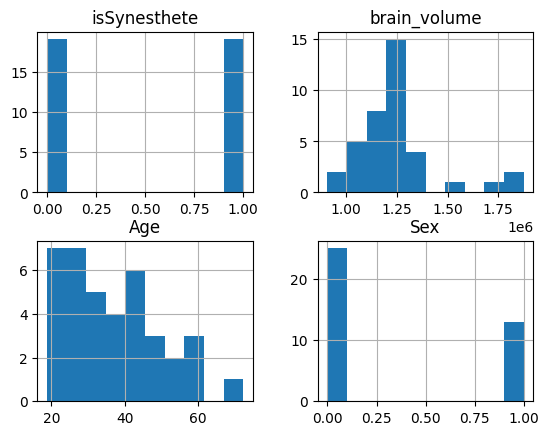

In [8]:
participants.hist()

array([[<Axes: title={'center': 'Sex'}>, <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'brain_volume'}>, <Axes: >]], dtype=object)

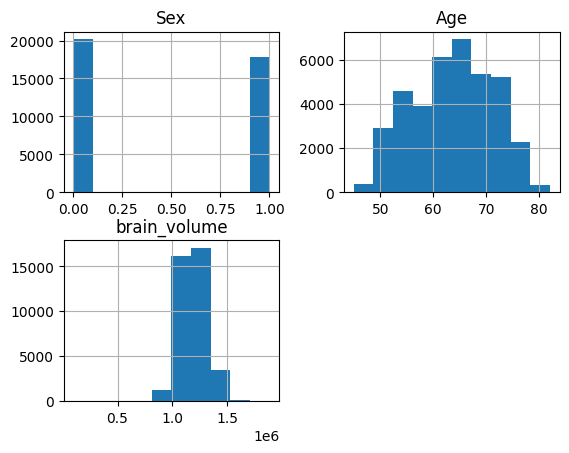

In [9]:
participants_ukb = pd.read_csv(participants_ukb_file, index_col=0)
participants_ukb = participants_ukb[["Sex", "Age", "BrainVolumeFreeSurfer_mm3"]].rename(columns={"BrainVolumeFreeSurfer_mm3": "brain_volume"})
participants_ukb.hist()

In [10]:
def is_it_a_file(sub_dir):
    if os.path.isdir(sub_dir):
        return False
    else:
        logging.debug(f"{sub_dir} is a file. Continue.")
        return True
    

def is_folder_a_model(sub_dir):
    if os.path.exists(sub_dir+'/.hydra/config.yaml'):
        return True
    else:
        logging.debug(f"\n{sub_dir} not associated to a model. Continue")
        return False

def get_model_paths(dir_path, result = None):
    """Recursively gets all models included in dir_path"""
    if result is None:  # create a new result if no intermediate was given
        result = [] 
    for name in os.listdir(dir_path):
        sub_dir = dir_path + '/' + name
        # checks if directory
        if is_it_a_file(sub_dir):
            pass
        elif not is_folder_a_model(sub_dir):
            result.extend(get_model_paths(sub_dir))
        else:
            result.append(sub_dir)
    return result

In [11]:
model_paths = get_model_paths(path_champollion)

In [12]:
models_df = pd.DataFrame({"path":model_paths})

In [13]:
# df = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
# pca = PCA(n_components=1)
# df2 = pd.DataFrame(pca.fit_transform(df))
# df2.index = df.index
# df2


In [14]:
def compute(model_path, random_state):
    global embeddings
    global participants
    global results, X, Y, df2
    # Gets region name
    cfg = omegaconf.OmegaConf.load(model_path+'/.hydra/config.yaml')
    region = cfg['dataset'][next(iter(cfg['dataset']))]['crop_dir'].split('/')[-3]
    side = next(iter(cfg['dataset'])).split('_')[-1]
    region = region + '_' + side
    model_name = model_path.split('/')[-1]
    region_path = '/'.join(model_path.split('/')[-2:])
    print(f"Treating {region}: {region_path} : {model_path}")
    
    # Loads embeddings
    embeddings = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
    merged = participants[[label] + covariates].merge(embeddings, left_index=True, right_index=True)

    # Residualizes using ukb embeddings
    embeddings_ukb = pd.read_csv(f"{model_path}/{ukb_embeddings_subpath}", index_col=0)
    phenotypes_cols = embeddings_ukb.columns # Supposes that phenotype names are identical
    merged_ukb = participants_ukb[covariates].merge(embeddings_ukb, left_index=True, right_index=True)
    
    resid_df = merged[[label]].copy()
    resid_df.loc[:, phenotypes_cols] = 0.0
    resid_df_ukb = merged_ukb[covariates].copy()
    resid_df_ukb.loc[:, phenotypes_cols] = 0.0

    for dim_i in phenotypes_cols:
        X = merged_ukb[covariates]
        X = sm.add_constant(X)
        y = merged_ukb[dim_i]
        model = sm.OLS(y, X).fit()
        ypred = model.predict(X)
        residuals = y - ypred
        resid_df_ukb.loc[:, dim_i] = residuals

        X = merged[covariates]
        X = sm.add_constant(X)
        y = merged[dim_i]
        ypred = model.predict(X)
        residuals = y - ypred
        resid_df.loc[:, dim_i] = residuals

    # Merge
    merged = participants[[label]].merge(resid_df[phenotypes_cols], left_index=True, right_index=True)

    # Makes PCA on UkBioBank residuals
    pca = PCA(n_components=3)
    pca.fit(resid_df_ukb.loc[:, phenotypes_cols])

    # Gets synesthete residuals
    X = resid_df.loc[:, phenotypes_cols]
    Y = resid_df[[label]]

    # Transforms in synesthete dataset
    df2 = pd.DataFrame(pca.transform(X))
    df2.index = X.index

    # Makes OLS
    df2 = sm.add_constant(df2)
    model = sm.OLS(Y[label], df2)
    results = model.fit()
    f_value = results.fvalue
    p_value = results.f_pvalue

    # Gets result
    # roc_auc = roc_auc_score(Y, proba_pred[:,1])
    print(f_value, p_value)
    
    # Returns result
    return (region, f_value, p_value, model_name, region_path, model_path)

In [15]:
participants.dtypes

isSynesthete      int64
brain_volume    float64
Age             float64
Sex               int64
dtype: object

In [16]:
result = []
for random_state in range(1):

    # Computes AUC
    for model_path in model_paths:
        result.append(compute(model_path, random_state))

Treating S.C.-sylv._left: SC-sylv_left/11-43-38_2 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2
1.4486262660535973
Treating S.C.-sylv._left: SC-sylv_left/14-00-57_116 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116
0.651531940575564
Treating S.F.inter.-S.F.sup._left: SFinter-SFsup_left/09-33-02_0 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0
0.08481464078554508
Treating S.T.i.-S.T.s.-S.T.pol._right: STi-STs-STpol_right/20-15-00_117 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117
0.10645501229870184
Treating F.Coll.-S.Rh._right: FColl-SRh_right/09-45-57_1 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1
0.0602049920954494
Treating S.T.s.-S.GSM._left: STs-SGSM_left/13-57-40_59 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/STs-SGSM_left/13-

In [17]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           isSynesthete   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.9187
Date:                Wed, 09 Oct 2024   Prob (F-statistic):              0.442
Time:                        10:18:42   Log-Likelihood:                -26.099
No. Observations:                  38   AIC:                             60.20
Df Residuals:                      34   BIC:                             66.75
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5407      0.091      5.922      0.000       0.355       0.726
0             -0.0002      0.000     -0.558      0.581      -0.001       0.001
1              0.0004      0.001      0.773      0.445      -0.001       0.002
2              0.0005      0.001      0.964      0.342      -0.001       0.002
==============================================================================
Omnibus:                       71.753   Durbin-Watson:                   2.150
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                4.687
Skew:                          -0.012   Prob(JB):                       0.0960
Kurtosis:                       1.280   Cond. No.                         231.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
df = pd.DataFrame(result, columns=['region', 'f_value', 'p_value', 'model_name', 'region_path', 'model_path'])

In [19]:
df

,region,f_value,p_value,model_name,region_path,model_path
0,S.C.-sylv._left,1.448626,0.245863,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...
1,S.C.-sylv._left,0.651532,0.587493,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...
2,S.F.inter.-S.F.sup._left,0.084815,0.967870,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...
3,S.T.i.-S.T.s.-S.T.pol._right,0.106455,0.955745,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...
4,F.Coll.-S.Rh._right,0.060205,0.980324,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...
...,...,...,...,...,...,...
93,S.C.-S.Po.C._left,0.684217,0.567876,16-46-17_3,SC-SPoC_left/16-46-17_3,/neurospin/dico/data/deep_folding/current/mode...
94,S.C.-S.Po.C._left,0.293161,0.830037,16-46-17_0,SC-SPoC_left/16-46-17_0,/neurospin/dico/data/deep_folding/current/mode...
95,S.C.-S.Po.C._left,1.642360,0.197845,14-55-36_0,SC-SPoC_left/14-55-36_0,/neurospin/dico/data/deep_folding/current/mode...
96,S.C.-S.Po.C._left,0.412431,0.745121,16-46-17_1,SC-SPoC_left/16-46-17_1,/neurospin/dico/data/deep_folding/current/mode...


In [20]:
df['side'] = df['region'].str.split('_').str[-1]

In [21]:
df

,region,f_value,p_value,model_name,region_path,model_path,side
0,S.C.-sylv._left,1.448626,0.245863,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...,left
1,S.C.-sylv._left,0.651532,0.587493,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...,left
2,S.F.inter.-S.F.sup._left,0.084815,0.967870,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...,left
3,S.T.i.-S.T.s.-S.T.pol._right,0.106455,0.955745,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...,right
4,F.Coll.-S.Rh._right,0.060205,0.980324,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...,right
...,...,...,...,...,...,...,...
93,S.C.-S.Po.C._left,0.684217,0.567876,16-46-17_3,SC-SPoC_left/16-46-17_3,/neurospin/dico/data/deep_folding/current/mode...,left
94,S.C.-S.Po.C._left,0.293161,0.830037,16-46-17_0,SC-SPoC_left/16-46-17_0,/neurospin/dico/data/deep_folding/current/mode...,left
95,S.C.-S.Po.C._left,1.642360,0.197845,14-55-36_0,SC-SPoC_left/14-55-36_0,/neurospin/dico/data/deep_folding/current/mode...,left
96,S.C.-S.Po.C._left,0.412431,0.745121,16-46-17_1,SC-SPoC_left/16-46-17_1,/neurospin/dico/data/deep_folding/current/mode...,left


In [22]:
def plot_horizontal(res, region_name, ax, f_value, p_value, f2_value, visible, title):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)
    
    res = res.sort_values(by=f_value, ascending=True)

    # ax.errorbar(res[AUC_name], res[region_name], res[std_auc_name], fmt='s', color='black')
    # ax.scatter(res[AUC_name], res[region_name], marker='s', color='black')
    ax.axvline(x=-np.log10(0.05/56), color='black', linestyle='-')
    ax.barh(res[region_name], -np.log10(res[f2_value]), fill=True, color='lightgray')
    ax.errorbar(res[f_value], res[region_name], xerr=0, fmt='s', color='black')
    # if visible:
    #     ax.set_ylabel("AUC ensemble")
    # else:
    #     ax.get_yaxis().set_ticks([])
    # ax.set_xlim((0.3, 1.0))
    ax.set_title(title)


In [23]:
0.05/56

0.0008928571428571429

In [24]:
df.sort_values(by="f_value", ascending=False)

,region,f_value,p_value,model_name,region_path,model_path,side
23,S.Or.-S.Olf._left,3.502467,0.025720,18-00-16_0,SOr-SOlf_left/18-00-16_0,/neurospin/dico/data/deep_folding/current/mode...,left
53,S.T.s.br._right,3.423111,0.027976,16-33-12_1,STsbr_right/16-33-12_1,/neurospin/dico/data/deep_folding/current/mode...,right
17,S.F.inf.-BROCA-S.Pe.C.inf._right,3.382950,0.029195,16-50-50_0,SFinf-BROCA-SPeCinf_right/16-50-50_0,/neurospin/dico/data/deep_folding/current/mode...,right
82,ORBITAL_left,2.924019,0.047801,11-50-30_16,ORBITAL_left/11-50-30_16,/neurospin/dico/data/deep_folding/current/mode...,left
26,F.Coll.-S.Rh._left,2.786910,0.055492,09-45-57_0,FColl-SRh_left/09-45-57_0,/neurospin/dico/data/deep_folding/current/mode...,left
...,...,...,...,...,...,...,...
61,S.T.s.-S.GSM._right,0.160576,0.922111,11-40-07_0,STs-SGSM_right/11-40-07_0,/neurospin/dico/data/deep_folding/current/mode...,right
3,S.T.i.-S.T.s.-S.T.pol._right,0.106455,0.955745,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...,right
62,S.Po.C._right,0.092707,0.963559,18-08-26_1,SPoC_right/18-08-26_1,/neurospin/dico/data/deep_folding/current/mode...,right
2,S.F.inter.-S.F.sup._left,0.084815,0.967870,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...,left


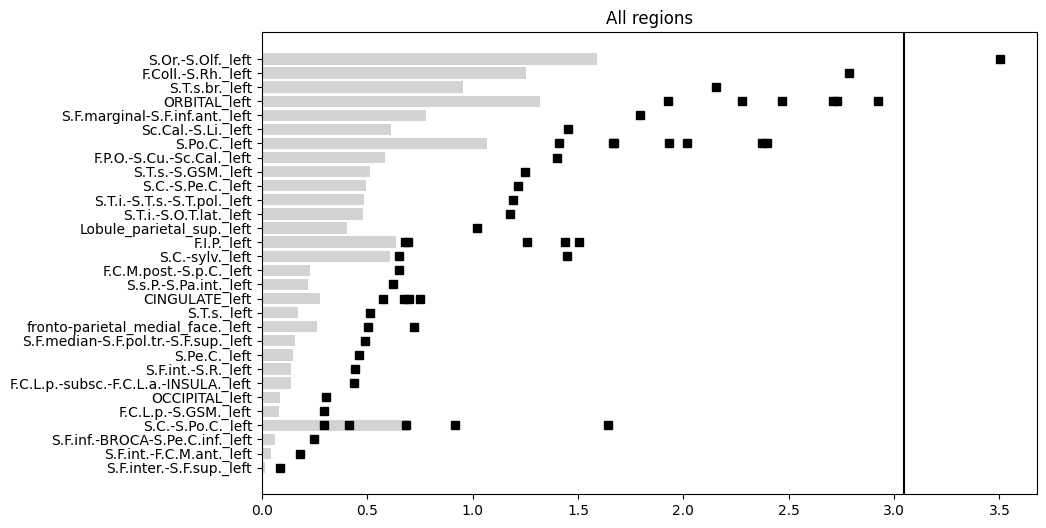

In [25]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='left'], "region", ax, "f_value", "f_value", "p_value",  True, "All regions")
plt.show()

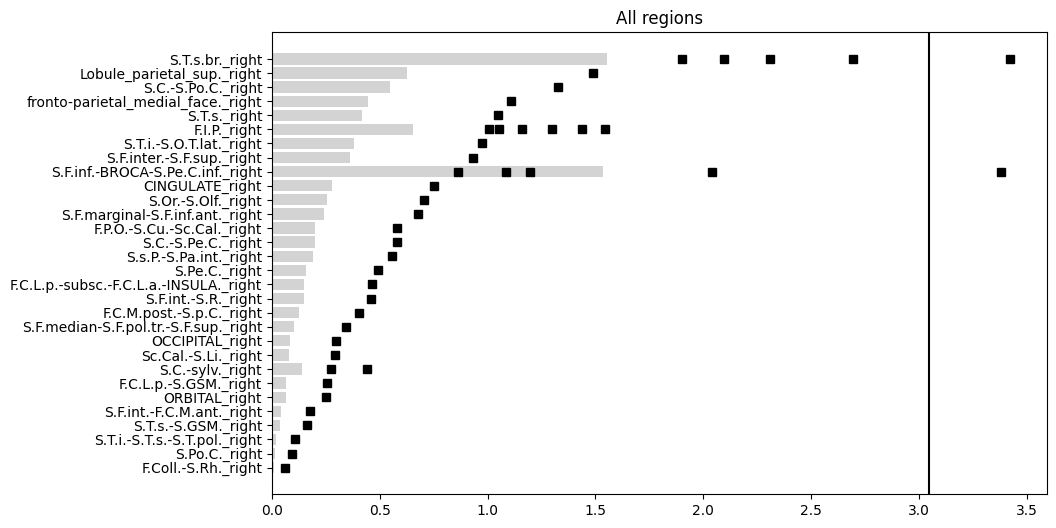

In [26]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='right'], "region", ax, "f_value", "p_value", "p_value",  True, "All regions")
plt.show()

In [27]:
# df.to_csv(output_filename)